## Predicting Population Changer with ONS Mortality Data

## Script Output: Animated visualisation GIF that shows population change over time for a fictional town.

In [1]:
import pandas as pd
import math

## Name the directory you want to save the GIF visual to.

In [2]:
directory = 'C:/Users/steph/OneDrive/Documents/GitHub/MSc/'

## Read in ONS mortality rates

In [3]:
# Get the mortality rates of men from the ONS xlsx sheet
mortality_rates = pd.read_excel('qxtimeseries.xlsx', sheet_name='UK Males qx', header = 4)
mortality_rates_2019_male = mortality_rates[['age', '2017-2019']].copy()
mortality_rates_2019_male.rename(columns={'age':'age',"2017-2019": "2017-2019_Male"}, inplace =True)

In [4]:
# Get the mortality rates of wommen from the ONS xlsx sheet
mortality_rates = pd.read_excel('qxtimeseries.xlsx', sheet_name='UK Females qx', header = 4)
mortality_rates_2019_female = mortality_rates[['age', '2017-2019']].copy()
mortality_rates_2019_female.rename(columns={'age':'age',"2017-2019": "2017-2019_Female"}, inplace =True)

In [5]:
#combine the male and female mortality rates
mortality_rates = pd.merge( mortality_rates_2019_male, mortality_rates_2019_female, how = 'outer', on = 'age')
mortality_rates

,age,2017-2019_Male,2017-2019_Female
0,0,0.004267,0.003536
1,1,0.000243,0.000213
2,2,0.000132,0.000127
3,3,0.000101,0.000098
4,4,0.000097,0.000068
...,...,...,...
96,96,0.288494,0.251390
97,97,0.306274,0.268554
98,98,0.328778,0.294374
99,99,0.368071,0.315445


In [6]:
# Get the current initial information for year 0

## Read in some census data - (fabricated using Python Faker Library)

In [7]:
# Read in some census data - (fabricated using Python Faker Library)
census_df = pd.read_csv('census_08_new.csv')

In [8]:
census_df.sample(10)

,House Number,Street,First Name,Surname,Age,Relationship to Head of House,Marital Status,Gender,Occupation,Infirmity,Religion
7984,42,Shah Freeway,Ruth,Wilson,24,Head,Married,Female,Quality manager,None,Jewish
4652,2,Clayton Avenue,Fiona,Smith,41,Wife,Married,Female,General practice doctor,None,Catholic
4250,38,Mason Street,Danny,Norman,23,Husband,Married,Male,Unemployed,None,None
9629,25,Field Corner,Joan,Harper,25,Daughter,Single,Female,"Doctor, hospital",None,None
10115,1,Trent Bastion,Maria,Jackson,33,Head,Married,Female,Estate agent,None,None
380,97,Woodward Street,Norman,Patterson,12,Son,NaN,Male,Student,None,NaN
7073,2,Sandy Squares,Michael,Jenkins,55,Husband,Married,Male,"Physicist, medical",None,None
2299,96,Falcon Lane,Joanna,Roberts-Patel,30,Head,Married,Female,"Programmer, systems",None,None
9078,12,Peninsula Road,Christine,Reynolds,44,Head,Single,Female,Chief Executive Officer,None,None
6585,18,Jones Lane,Jake,Watts,54,Husband,Married,Male,Arts administrator,None,Sikh


In [9]:
# Problematic Ages
census_df['Age'].value_counts().tail(21)

57.15935784    1
109            1
               1
104            1
2.2            1
58.15935784    1
4.5            1
69.83970697    1
81.98805985    1
0.5            1
Three          1
One            1
97             1
84.98805985    1
100            1
Eight          1
72.05604773    1
74.05604773    1
96             1
-1             1
400            1
Name: Age, dtype: int64

# Clean the Ages Column

In [10]:
# Script for converting text to string.

census_df['Age'] = census_df['Age'].astype(str)

census_df['Age'].value_counts().to_frame().tail(22)

# Some variables used for cleaning instatiated here

units = [
        "zero", "one", "two", "three", "four", "five", "six", "seven", "eight",
        "nine", "ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen",
        "sixteen", "seventeen", "eighteen", "nineteen",
                ]

tens = ["", "", "twenty", "thirty", "forty", "fifty", "sixty", "seventy", "eighty", "ninety"]

scales = ["hundred", "thousand", "million", "billion", "trillion"]

number_words = units + tens + scales

# instantiate function for converting text age to numerical age

def text2int(textnum, numwords={}):
    """
    Input: textnum: This function takes in a a number written in english characters all lower case as a string:
    Ouput: returns an integer value of the written number.
    
    """
    
    if not numwords:
        units = [
                "zero", "one", "two", "three", "four", "five", "six", "seven", "eight",
                "nine", "ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen",
                "sixteen", "seventeen", "eighteen", "nineteen",
                ]

        tens = ["", "", "twenty", "thirty", "forty", "fifty", "sixty", "seventy", "eighty", "ninety"]

        scales = ["hundred", "thousand", "million", "billion", "trillion"]

        numwords["and"] = (1, 0)
        for idx, word in enumerate(units):    numwords[word] = (1, idx)
        for idx, word in enumerate(tens):     numwords[word] = (1, idx * 10)
        for idx, word in enumerate(scales):   numwords[word] = (10 ** (idx * 3 or 2), 0)

    current = result = 0
    for word in textnum.split():
        if word not in numwords:
            raise Exception("Illegal word: " + word)

        scale, increment = numwords[word]
        current = current * scale + increment
        if scale > 100:
            result += current
            current = 0

    return result + current

In [11]:
# Dealing with impossible  ages

# If the age contains a negative value, remove from data set!
# Why? Because it is either an error or the human doesn't exist yet

# Simple subset, cast and index reset (as we are removing a row the indexes will not automatically shift).
census_df = census_df[~census_df.Age.str.contains("-")]
census_df = census_df.astype(str)
census_df.reset_index(inplace=True, drop = True)

# Dealing with float ages

# The answers that are floats could represent one of two things, either a decimal point has been added in error, as in , ‘4.5’ meaning 45. Filtering for the presence of a point, ‘.’, and occupation not being ‘Child’ or 'Student' allows this to be imputed correctly. (As you don’t generally get employed children.)
# Alternatively, it represents a partial year in which case the value is simply round down to the nearest integer with the math.floor function


def split(word):
    """
    A function that splits a word into a list of its contained characters
    This is useful for detecting '.' values as Python typically sees '.' as placeholders, not periods. 
    """
    return [char for char in word]

# Round all the floats down
for i, age_string in enumerate(census_df['Age']):
    

    if ('.' in split(age_string)) and (census_df['Occupation'].iloc[i] != 'Child') and (census_df['Occupation'].iloc[i] != 'Student') and (len(split(age_string))==3):
        census_df.at[i, 'Age'] = str(split(age_string)[0])+str(split(age_string)[2])
    else:
        try:
            age_string = math.floor(float(age_string))
            census_df.at[i, 'Age'] = str(age_string)
        except ValueError:
            pass
    

# Dealing with text ages
# Using the beautiful function a few cells up to convert from text to integer, then temporarily for uniformity back into a string.

# Show the non-numerical age values
[x for x in census_df['Age'] if x.isdigit() == False]

# Apply the function to every cell that contains a number word
for i, age_string in enumerate(census_df['Age']):
    
    if age_string.lower() in number_words:
        census_df.at[i, 'Age'] = str(text2int(age_string.lower()))
    else:
        pass

# Dealing with impossible and missing ages

# There is an age of 400 years old.

# In this case we will impute with the average age along with missing ages

# If the age exceeds the current world record of 122 years old impute with the average
for i, age_string in enumerate(census_df['Age']):
    try:
        age_string = int(age_string)
        if age_string >= 122:
            print(age_string)
    except:
        pass

# Dealing with missing/ ridiculous ages
# At this point every string in the age column should be entirely numeric strings except the blank,  '   ', entry .
# This can now be imputed with the average of all the other ages in the column

print('The last value/s to impute is/are: '+str([x for x in census_df['Age'] if x.isdigit() == False]))

# Getting the average value of all the purely numerical remaining strings in the df by subsetting for them
temp = census_df[census_df.Age.str.isnumeric()].copy()

# Ensure all values are integers- will return error if they aren't
temp['Age'] = temp['Age'].astype(int)

# Ensure all the values are below world record age by subsetting. Note this should leave the df unchanged at this point
temp2 = temp[temp['Age'] <= 122]

# Get the average
avg_age = math.floor(temp2['Age'].mean())
print("This can be done with the average age of all the other ages: "+str(avg_age))

# Test to see if the same is returned without subsetting for ages below 122, could reveal need for fruther investigation
avg_age = math.floor(temp['Age'].mean())


# Imputation with average
for i, age_string in enumerate(census_df['Age']):
    
    if (age_string.isnumeric() is False) or (int(age_string) >122):
        # Print values being imputed
        print(age_string.lower())
        census_df.at[i, 'Age'] = str(avg_age)
    else:
        pass

# Convert the column to integer.
# If this works without a type error it proves success.

# Convert
census_df['Age'] = census_df['Age'].astype(int)

# Check type for int32
census_df.dtypes

# Inspect a sample of the data set
census_df.sample(5)

400
The last value/s to impute is/are: [' ']
This can be done with the average age of all the other ages: 36
400
 


,House Number,Street,First Name,Surname,Age,Relationship to Head of House,Marital Status,Gender,Occupation,Infirmity,Religion
3415,21,Leisuretun Road,Katie,Lee,5,Daughter,nan,Female,Student,None,nan
8862,12,Albans Lane,Mohammed,Cox,64,Head,Married,Male,Information systems manager,None,None
2726,9,Taurusplace Drive,Dawn,Smith,16,Daughter,nan,Female,Student,None,nan
251,61,Woodward Street,Denise,Brady,21,Daughter,Single,Female,University Student,None,Christian
5008,10,Quayside Tunnel,Carolyn,King,69,Head,Widowed,Female,Retired Energy engineer,None,Christian


# Clean Gender Column Using API Get Request 

In [12]:
import requests

# Iterate through every row by indexing them with the .at method labeling every row 'x'
for x in range(len(census_df['Gender'])):
    # If the string starts with an m assign string label 'male' to the cell
    if census_df.at[x, 'Gender'].lower().startswith("m"):
        census_df.at[x, 'Gender'] = "male"
        
    # If the string starts with an f assign string label 'female' to the cell    
    elif census_df.at[x, 'Gender'].lower().startswith("f"):
        census_df.at[x, 'Gender'] = "female"
        
    # If cell is something else use a get request to search for a individuals first name on https://genderize.io/
    # Return a string of their most likely classification and assign it to the cell
    # Else if sex left blank, alternatively a new class could be given, "undisclosed".
    else:
        response = requests.get("https://api.genderize.io?name="+census_df.at[x, 'First Name'])
        census_df.at[x, 'Gender'] = response.json()['gender']


# Model Population Change

In [13]:
age_subset = census_df[['Age','Gender']].copy()
age_subset.head()

,Age,Gender
0,72,female
1,23,female
2,25,male
3,44,female
4,47,male


In [14]:
# Reset the index
age_subset.reset_index(drop=True, inplace = True)

In [15]:
# Make a function that models the number of birth in a year from the current years data set
def get_births(df):
    """
    This function takes in the census dataframe and outputs an integer number of babies born that year
    for the women in a 10 year fertility window 25 to 34.
    """
    birthrate = 1.65/10
    females_fertile = len(     df[     (df['Age'] >= 25) &(df['Age'] < 35)& (df['Gender'] == 'female')]                )
    new_babies = math.ceil(females_fertile * birthrate)
    # Round up the the nearest even number, so even amount of boys and girls can be born
    if new_babies % 2 == 0:
        pass
    else:
        new_babies = new_babies+ 1
    return new_babies

# Note the cell below takes a long time to load

## This is where the year on year modeling takes place fro 80 years into the future
## - a data frame is added to a list for every year
## - a list of tuples is also grown counting for births, deaths, retirees, and total population year-on-year

In [16]:
import random

# make a list of dfs to append to in each years iteration over
list_of_dfs = list()
list_of_dfs.append(age_subset)


# make a list of the pop counts
list_of_pop_counts=list()

# Totals list of tuples
totals = list()

for year in range(77):
    
    baby = get_births(age_subset)
    
    
        #Add babies
    
    temp_baby_list = []

    for x in range(int((baby)/2)):
    
        temp_baby_list.append([-1, 'male'])
        temp_baby_list.append([-1, 'female'])
    
    
    
    baby_frame = pd.DataFrame(temp_baby_list,columns=['Age','Gender'])

    age_subset  = age_subset.append(baby_frame, ignore_index = True).copy()
    list_of_dfs.append(age_subset)
    
    age_subset.reset_index(drop=True, inplace = True)
    
    # add a year to all the ages
    age_subset['Age'] = age_subset['Age'] + 1
    
    print(len(age_subset))
    # Filter out the dead
    """age_subset = age_subset.nsmallest( (len(age_subset) -dead) , 'Age')"""
    
    
    # get some values for the counts later assessment
    sixty_six_or_over = len(age_subset[age_subset['Age']>=66])
    total_pop = len(age_subset)
    
    # THE KILLING
    list_to_kill = []
    # For every person decide do get there age, get the mortality rate, and role the death dice
    for index  ,  person in age_subset.iterrows():
        if person['Age'] <=100:
            age = person['Age']
        else:
            age = 100
            
        # Get the mortality rate
        gender = person['Gender']
        if gender == 'female':
            death_rate = mortality_rates[mortality_rates['age']==age]["2017-2019_Female"].values[0]
        elif gender == 'male':
            death_rate = mortality_rates[mortality_rates['age']==age]["2017-2019_Male"].values[0]
    
        # Role the death dice
        death_dice = random.random()
        if death_dice < death_rate:
            list_to_kill.append(index)    
        else:
            pass
        
    # Remove all the deceased in index from the list
    age_subset = age_subset.drop(list_to_kill, axis = 0, errors = 'raise')
    
    # Print the outcomes
    print("year: " + str(year) + "   babies born: " + str(baby)  + "   dead: " + str(len(list_to_kill)))
    
    # Keep a track of the totals
    totals.append((year,baby,len(list_to_kill),sixty_six_or_over,total_pop))



10297
year: 0   babies born: 124   dead: 68
10347
year: 1   babies born: 118   dead: 84
10379
year: 2   babies born: 116   dead: 52
10443
year: 3   babies born: 116   dead: 67
10492
year: 4   babies born: 116   dead: 63
10551
year: 5   babies born: 122   dead: 56
10615
year: 6   babies born: 120   dead: 59
10680
year: 7   babies born: 124   dead: 78
10730
year: 8   babies born: 128   dead: 79
10781
year: 9   babies born: 130   dead: 80
10831
year: 10   babies born: 130   dead: 73
10888
year: 11   babies born: 130   dead: 89
10929
year: 12   babies born: 130   dead: 77
10982
year: 13   babies born: 130   dead: 88
11024
year: 14   babies born: 130   dead: 85
11063
year: 15   babies born: 124   dead: 94
11091
year: 16   babies born: 122   dead: 90
11121
year: 17   babies born: 120   dead: 97
11140
year: 18   babies born: 116   dead: 97
11159
year: 19   babies born: 116   dead: 94
11181
year: 20   babies born: 116   dead: 72
11225
year: 21   babies born: 116   dead: 112
11225
year: 22   ba

# Note the cell below takes a long time to load

# Make a gif of all the years to see the change over time

In [17]:
# Make a gif of all the years to see the chaneg over time
# Make sure to include an underlay of the original year
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(12,12)})

# done by making a png of every years dataframe made in previous cell
# then compiling into GIF
# then deleting all the pngs used to make the gif


# Make a list of file names

filenames = []


for x in range(len(list_of_dfs)):
    
    fig, ax = plt.subplots()
    sns.histplot(x = list_of_dfs[x]['Age'], binwidth = 10, discrete = True)
    sns.histplot(x = list_of_dfs[0]['Age'], binwidth = 10, alpha = 0.2, color = 'r', linewidth=0, discrete = True)
    ax.set_xlim(0,120)
    ax.set_ylim(0,259)

    plt.text(60, 210,
             "Year: 20"+str(x+21),
             horizontalalignment='left',
             size='large',
             color='black',
             weight='semibold',
             fontsize = 50)
    
    plt.text(10, 200,
             "Year: 2021",
             horizontalalignment='left',
             size='large',
             color='r',
             weight='semibold',
             fontsize = 30, alpha = 0.2)
    
    
    plt.title('Population Age Counts')

    # Make the gif
    directory = directory
    filename = directory + str(x) + ".png"
    plt.savefig(filename, dpi = 60)
    filenames.append(filename)
    plt.clf()
    
    
number_of_frames = 15
    
import imageio
with imageio.get_writer(directory + 'Visualizations'  +'.gif', mode='i') as writer:

    for filename in filenames:
        image = imageio.imread(filename)
        for x in range(number_of_frames):
            writer.append_data(image)

# Remove unnecessary image files pngs
import os
for filename in set(filenames):
    os.remove(filename)

C:\Users\steph\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\steph\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\steph\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_op

C:\Users\steph\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\steph\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\steph\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_op

C:\Users\steph\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\steph\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\steph\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_op

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

# CHECK WORKING DIRECTORY FOR A BEAUTIFUL GIF VISUALIZATION OF POPULATION DISTRIBUTION CHANGING OVER TIME

In [18]:
# Make a df of all the year on year totals for births deaths retirees and total population

totals_col_names = ['Years From Now', 'Babies Born', 'Deaths','Retirees', 'Total Pop']
totals_df = pd.DataFrame(totals, columns = totals_col_names)
# totals_df.set_index('Years From Now', inplace = True)
totals_df

,Years From Now,Babies Born,Deaths,Retirees,Total Pop
0,0,124,68,1101,10297
1,1,118,84,1158,10347
2,2,116,52,1169,10379
3,3,116,67,1218,10443
4,4,116,63,1263,10492
...,...,...,...,...,...
72,72,86,153,2199,8605
73,73,86,181,2162,8538
74,74,86,126,2109,8443
75,75,86,134,2105,8403


# Making visuals for the above df

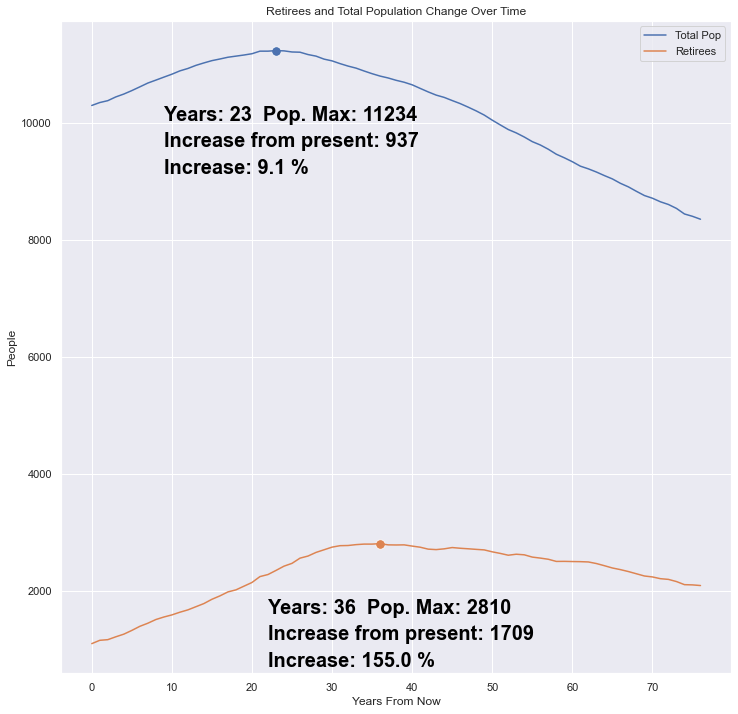

In [19]:
sns.set(rc={'figure.figsize':(12,12)})

# Line plot the data
sns.lineplot(data = totals_df, x='Years From Now', y = 'Total Pop', label = 'Total Pop')
sns.lineplot(data = totals_df, x='Years From Now', y = 'Retirees', label ='Retirees')

# get the max total population MARKER and the year it will be
pop_max_pop = totals_df['Total Pop'].max()
pop_max_year = totals_df[totals_df['Total Pop'] == totals_df['Total Pop'].max()].iloc[0][0]
pop_max_pop_now = totals_df[['Total Pop']].iloc[0][0]
plt.text(y=pop_max_pop-1200, x=pop_max_year-14,
         s ="Years: "+str(pop_max_year)+"  Pop. Max: "+str(pop_max_pop),
         horizontalalignment='left',
         size='large',
         color='black',
         weight='semibold',
         fontsize = 20)       
sns.scatterplot(x=[pop_max_year] , y=[pop_max_pop], s = 90)            
plt.text(y=pop_max_pop-1650, x=pop_max_year-14,
         s ="Increase from present: " +  str(pop_max_pop-pop_max_pop_now)   ,
         horizontalalignment='left',
         size='large',
         color='black',
         weight='semibold',
         fontsize = 20)       
plt.text(y=pop_max_pop-2100, x=pop_max_year-14,
         s ="Increase: " +  str((round((pop_max_pop/pop_max_pop_now)-1, 3)*100)) + " %"   ,
         horizontalalignment='left',
         size='large',
         color='black',
         weight='semibold',
         fontsize = 20) 

# get the max total reitrees MARKER and the year it will be
ret_max_pop = totals_df['Retirees'].max()
ret_max_year = totals_df[totals_df['Retirees'] == totals_df['Retirees'].max()].iloc[0][0]
ret_max_pop_now = totals_df[['Retirees']].iloc[0][0]
plt.text(y=ret_max_pop-1200, x=ret_max_year-14,
         s ="Years: "+str(ret_max_year)+"  Pop. Max: "+str(ret_max_pop),
         horizontalalignment='left',
         size='large',
         color='black',
         weight='semibold',
         fontsize = 20)       
sns.scatterplot(x=[ret_max_year] , y=[ret_max_pop], s = 90)  
plt.text(y=ret_max_pop-1650, x=ret_max_year-14,
         s ="Increase from present: " +  str(ret_max_pop-ret_max_pop_now),
         horizontalalignment='left',
         size='large',
         color='black',
         weight='semibold',
         fontsize = 20) 
plt.text(y=ret_max_pop-2100, x=ret_max_year-14,
         s="Increase: " +  str((round((ret_max_pop/ret_max_pop_now)-1, 2)*100)) + " %"  ,
         horizontalalignment='left',
         size='large',
         color='black',
         weight='semibold',
         fontsize = 20) 

plt.ylabel('People')
plt.title('Retirees and Total Population Change Over Time')
plt.legend()

# Plot births and Deaths Over Time


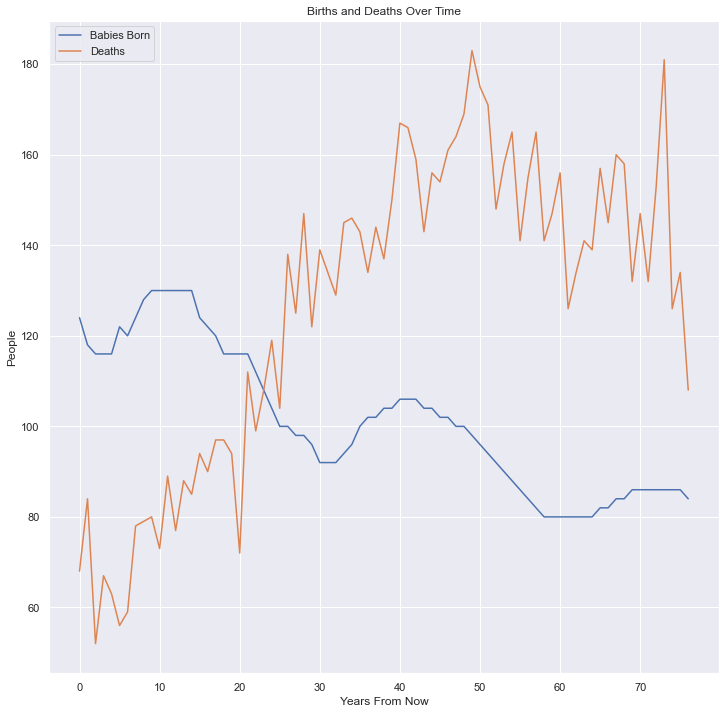

In [20]:
# Plot births and Deaths Over Time
sns.lineplot(data = totals_df, x='Years From Now', y = 'Babies Born', label ='Babies Born' )
sns.lineplot(data = totals_df, x='Years From Now', y = 'Deaths', label = 'Deaths')

plt.ylabel('People')
plt.title('Births and Deaths Over Time')
plt.legend()

# Same with moving average overlay and maxima and minima labels

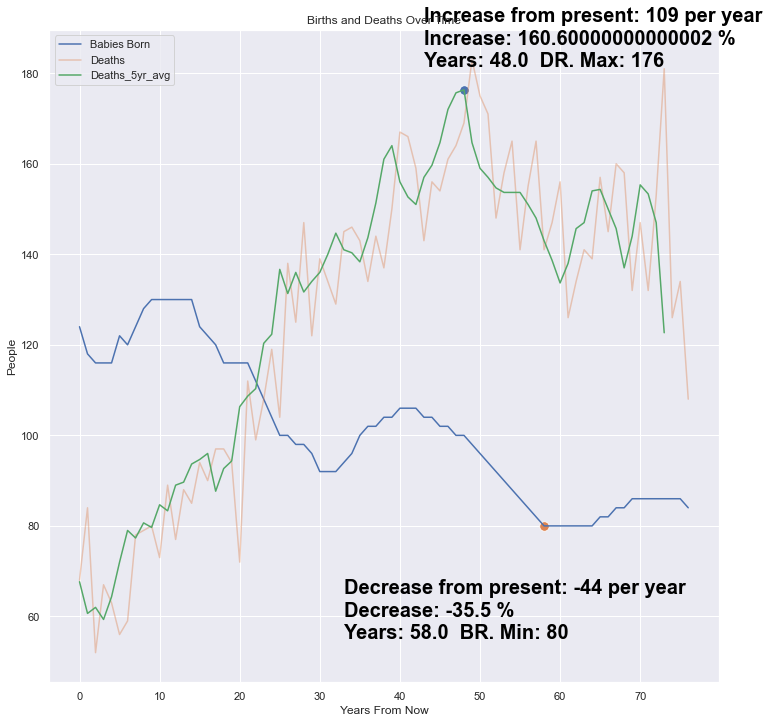

In [21]:
# Adding 5 year moving average to totals column

totals_df['5yr_Avg'] = totals_df['Deaths'].rolling(3).mean().shift(-3)

# Make the plot of births
sns.lineplot(data = totals_df, x='Years From Now', y = 'Babies Born', label ='Babies Born' )
#Make the plot of deaths (faded)
sns.lineplot(data = totals_df, x='Years From Now', y = 'Deaths', label = 'Deaths', alpha = 0.4)
# Make the plot of moving average deaths
sns.lineplot(data = totals_df, x='Years From Now', y = '5yr_Avg', label = 'Deaths_5yr_avg')

# Labels
plt.ylabel('People')
plt.title('Births and Deaths Over Time')

# get the max total deathrate MARKER and the year it will be
pop_max_pop = totals_df['5yr_Avg'].max()
pop_max_year = totals_df[totals_df['5yr_Avg'] == totals_df['5yr_Avg'].max()].iloc[0][0]
pop_max_pop_now = totals_df[['5yr_Avg']].iloc[0][0]

# Add text and peakpoint
plt.text(y=pop_max_pop+5, x=pop_max_year-5,
         s ="Years: "+str(pop_max_year)+"  DR. Max: "+str(round(pop_max_pop)),
         horizontalalignment='left',
         size='large',
         color='black',
         weight='semibold',
         fontsize = 20)       
sns.scatterplot(x=[pop_max_year] , y=[pop_max_pop], s = 90)            
plt.text(y=pop_max_pop+15, x=pop_max_year-5,
         s ="Increase from present: " +  str(round(pop_max_pop-pop_max_pop_now)) + " per year"  ,
         horizontalalignment='left',
         size='large',
         color='black',
         weight='semibold',
         fontsize = 20)       
plt.text(y=pop_max_pop+10, x=pop_max_year-5,
         s ="Increase: " +  str((round((pop_max_pop/pop_max_pop_now)-1, 3)*100)) + " %"   ,
         horizontalalignment='left',
         size='large',
         color='black',
         weight='semibold',
         fontsize = 20)


# get the min total BR MARKER and the year it will be
pop_max_pop = totals_df['Babies Born'].min()
pop_max_year = totals_df[totals_df['Babies Born'] == totals_df['Babies Born'].min()].iloc[0][0]
pop_max_pop_now = totals_df[['Babies Born']].iloc[0][0]

plt.text(y=pop_max_pop+5-30, x=pop_max_year-5-20,
         s ="Years: "+str(pop_max_year)+"  BR. Min: "+str(round(pop_max_pop)),
         horizontalalignment='left',
         size='large',
         color='black',
         weight='semibold',
         fontsize = 20)       
sns.scatterplot(x=[pop_max_year] , y=[pop_max_pop], s = 90)            
plt.text(y=pop_max_pop+15-30, x=pop_max_year-5-20,
         s ="Decrease from present: " +  str(round(pop_max_pop-pop_max_pop_now)) + " per year"  ,
         horizontalalignment='left',
         size='large',
         color='black',
         weight='semibold',
         fontsize = 20)       
plt.text(y=pop_max_pop+10-30, x=pop_max_year-5-20,
         s ="Decrease: " +  str((round((pop_max_pop/pop_max_pop_now)-1, 3)*100)) + " %"   ,
         horizontalalignment='left',
         size='large',
         color='black',
         weight='semibold',
         fontsize = 20)

plt.legend()

In [22]:
# We only need the age column